<a href="https://colab.research.google.com/github/gzmlab/Building-Agentic-AI-Systems/blob/main/Augmented_Strategic_Analyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!curl -LsSf https://astral.sh/uv/install.sh | sh && \
uv init && \
uv add langchain langgraph langchain-openai tavily-python beautifulsoup4 && \
uv sync && \
python -c "import langchain, langgraph, langchain.tools, bs4; \
print('✅ langchain:', getattr(langchain, '__version__', 'N/A'), '| langgraph:', getattr(langgraph, '__version__', 'N/A'), '| beautifulsoup4 (bs4):', getattr(bs4, '__version__', 'N/A'))"

downloading uv 0.8.1 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!
error: Project is already initialized in `/content` (`pyproject.toml` file exists)


In [31]:
import os
import json
import logging
from typing import TypedDict, List, Dict, Optional, Annotated
import operator # Pour le StateGraph
# ============== 4. Construction du Graphe ==============
import json # Pour le parsing JSON dans les noeuds

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from tavily import TavilyClient
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

# The API key can be read from os.environ["OPENAI_API_KEY"] automatically
# or by passing api_key to the client.
# Based on your usage elsewhere and Colab environment,
# we will retrieve the key from userdata.
from google.colab import userdata

# Configuration du logging (plus structuré que de simples print)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(module)s - %(message)s')
logger = logging.getLogger(__name__)

In [23]:
# Initialisez le LLM
from google.colab import userdata

# Load the OpenAI API key from Colab's secrets
try:
    openai_api_key = userdata.get("OPENAI_API_KEY")
    if not openai_api_key:
        raise ValueError("OPENAI_API_KEY not found in Colab secrets.")
    llm = ChatOpenAI(model="gpt-4", temperature=0, api_key=openai_api_key) # ou gpt-3.5-turbo pour économiser
    logger.info("LLM initialisé avec succès.")
except Exception as e:
    logger.error(f"Erreur lors de l'initialisation du LLM: {e}")
    llm = None # Gérer le cas où LLM ne peut pas être initialisé


# Initialisez le client de recherche
try:
    # Assuming TAVILY_API_KEY is also in Colab secrets
    tavily_api_key = userdata.get("TAVILY_API_KEY")
    if not tavily_api_key:
         raise ValueError("TAVILY_API_KEY not found in Colab secrets.")
    tavily = TavilyClient(api_key=tavily_api_key)
    logger.info("Client Tavily initialisé avec succès.")
except Exception as e:
    logger.error(f"Erreur lors de l'initialisation du client Tavily: {e}")
    tavily = None # Gérer le cas où Tavily ne peut pas être initialisé

ERROR:__main__:Erreur lors de l'initialisation du client Tavily: Secret TAVILY_API_KEY does not exist.


In [24]:
# ============== 1. Définition des Outils ==============
def web_search(query: str) -> List[Dict]:
    if not tavily:
        logger.error("Le client Tavily n'est pas initialisé. Recherche impossible.")
        return [{
            "url": "error",
            "content": "Client Tavily non initialisé",
            "error": True,
            "query": query
        }]
    try:
        results = tavily.search(query=query, search_depth="advanced", max_results=3) # Réduit pour démo/débogage
        logger.debug(f"Résultats bruts de Tavily: {results}")
        processed_results = [{"url": res["url"], "content": res["content"]} for res in results.get("results", [])]
        logger.info(f"🛠️ OUTIL web_search a trouvé {len(processed_results)} résultats.")
        return processed_results
    except Exception as e:
        logger.error(f"Erreur pendant la recherche Tavily pour '{query}': {e}")
        return [{"error": str(e), "query": query}]

In [25]:
# ============== 2. Définition de l'État du Graphe (AgentState) ==============
class AnalyzedTopic(TypedDict):
    clarified_topic: str
    key_questions: List[str]
    impact_domains: List[str]

class AgentState(TypedDict):
    original_topic: str
    analyzed_topic: Optional[AnalyzedTopic]
    search_queries: Optional[List[str]]
    search_results: Optional[List[Dict]]
    raw_search_content: Optional[str]
    synthesized_information: Optional[str]
    strategic_outputs: Optional[Dict]
    # Pour la gestion du flux et le débogage
    current_node: Optional[str] # Pour savoir quel noeud est en cours
    history: List[str] # Pour tracer les noeuds visités
    error_message: Optional[str]
    debug_messages: List[str]

In [26]:
# ============== 3. Définition des Nœuds du Graphe ==============

def add_debug_message(state: AgentState, message: str) -> AgentState:
    """Helper pour ajouter des messages de debug à l'état."""
    current_messages = state.get("debug_messages", [])
    current_messages.append(message)
    return {"debug_messages": current_messages}

def topic_analyzer_node(state: AgentState) -> AgentState:
    node_name = "topic_analyzer"
    logger.info(f"➡️ Entrée dans le nœud: {node_name}")
    state = add_debug_message(state, f"Entering {node_name}")

    topic = state["original_topic"]
    logger.debug(f"Sujet original pour {node_name}: '{topic}'")

    prompt_template = ChatPromptTemplate.from_messages([
        ("system", "Tu es un expert en analyse de sujets d'actualité. Ton rôle est d'identifier les entités clés, les questions soulevées et les domaines d'impact."),
        ("human", f"Analyse le sujet suivant : '{topic}'. "
                  "Fournis une version clarifiée du sujet, 3-5 questions clés que ce sujet soulève, et 3-5 domaines d'impact potentiels (ex: technologique, économique, social, réglementaire, concurrentiel). "
                  "Réponds en format JSON avec les clés 'clarified_topic' (string), 'key_questions' (list of strings), et 'impact_domains' (list of strings).")
    ])
    chain = prompt_template | llm

    analyzed_data = {}
    error_msg = None
    try:
        logger.debug(f"Prompt envoyé à LLM pour {node_name}: {prompt_template.format_messages(topic=topic)}")
        response = chain.invoke({"topic": topic})
        logger.debug(f"Réponse brute du LLM pour {node_name}: {response.content}")
        analyzed_data = json.loads(response.content)
        if not all(k in analyzed_data for k in ['clarified_topic', 'key_questions', 'impact_domains']):
            raise ValueError("Réponse JSON mal formatée ou clés manquantes.")
        logger.info(f"Sujet analysé par {node_name}: {analyzed_data}")
        state = add_debug_message(state, f"{node_name} a analysé le sujet: {analyzed_data.get('clarified_topic')}")

    except json.JSONDecodeError as e:
        error_msg = f"Erreur de parsing JSON dans {node_name}: {e}. Réponse brute: {response.content if 'response' in locals() else 'N/A'}"
        logger.error(error_msg)
    except ValueError as e:
        error_msg = f"Erreur de validation des données dans {node_name}: {e}. Réponse JSON: {analyzed_data}"
        logger.error(error_msg)
    except Exception as e:
        error_msg = f"Erreur inattendue dans {node_name}: {e}"
        logger.error(error_msg)

    if error_msg:
        state = add_debug_message(state, error_msg)
        analyzed_data = {"clarified_topic": "ERREUR D'ANALYSE", "key_questions": [], "impact_domains": []} # Fallback

    history = state.get("history", []) + [node_name]
    logger.info(f"⬅️ Sortie du nœud: {node_name}")
    return {
        **state,  # Preserve existing state
        "analyzed_topic": analyzed_data,
        "search_queries": analyzed_data.get("key_questions", []),
        "error_message": state.get("error_message") or error_msg,
        "current_node": node_name,
        "history": history,
        "debug_messages": state.get("debug_messages")
    }

In [ ]:
def search_agent_node(state: AgentState) -> AgentState:
    node_name = "search_agent"
    logger.info(f"➡️ Entrée dans le nœud: {node_name}")
    state = add_debug_message(state, f"Entering {node_name}")

    queries = state.get("search_queries")
    original_topic = state.get("original_topic", "")
    error_msg = state.get("error_message") # Récupérer les erreurs précédentes

    all_results_content_parts = []
    collected_results_for_state = []

    if not queries:
        error_msg = f"Aucune requête de recherche fournie à {node_name}."
        logger.warning(error_msg)
        state = add_debug_message(state, error_msg)
    else:
        logger.info(f"{node_name} va traiter {len(queries)} requêtes.")
        for i, query in enumerate(queries):
            full_query = f"{original_topic} - {query}" # Pour plus de contexte
            logger.debug(f"Requête de recherche {i+1}/{len(queries)} pour {node_name}: '{full_query}'")
            state = add_debug_message(state, f"{node_name} recherche: '{full_query}'")
            search_call_results = web_search.invoke({"query": full_query}) # L'outil logge déjà en interne

            if search_call_results and isinstance(search_call_results, list) and search_call_results[0].get("error"):
                err = search_call_results[0]["error"]
                logger.error(f"Erreur de l'outil de recherche pour '{full_query}': {err}")
                state = add_debug_message(state, f"Erreur de recherche pour '{full_query}': {err}")
                # On pourrait choisir d'arrêter ou de continuer avec les résultats partiels
            elif search_call_results:
                for res_idx, res in enumerate(search_call_results):
                    content_part = f"Source URL {res_idx+1}: {res.get('url', 'N/A')}\nContent: {res.get('content', 'N/A')}\n\n"
                    all_results_content_parts.append(content_part)
                    collected_results_for_state.append({"url": res.get('url'), "snippet": res.get('content', '')[:300]+"..."})
                logger.info(f"{len(search_call_results)} résultats trouvés pour '{full_query}'.")
                state = add_debug_message(state, f"{len(search_call_results)} résultats pour '{full_query}'.")
            else:
                logger.warning(f"Aucun résultat pour la requête: '{full_query}'")
                state = add_debug_message(state, f"Aucun résultat pour '{full_query}'.")

    final_raw_content = "\n".join(all_results_content_parts) if all_results_content_parts else "Aucun contenu trouvé."
    logger.debug(f"Contenu brut total collecté par {node_name}:\n{final_raw_content[:500]}...") # Affiche le début

    history = state.get("history", []) + [node_name]
    logger.info(f"⬅️ Sortie du nœud: {node_name}")
    return {
        "raw_search_content": final_raw_content,
        "search_results": collected_results_for_state,
        "error_message": error_msg,
        "current_node": node_name,
        "history": history,
        "debug_messages": state.get("debug_messages")
    }

In [ ]:
def information_synthesizer_node(state: AgentState) -> AgentState:
    node_name = "information_synthesizer"
    logger.info(f"➡️ Entrée dans le nœud: {node_name}")
    state = add_debug_message(state, f"Entering {node_name}")

    content_to_synthesize = state.get("raw_search_content")
    original_topic = state.get("original_topic")
    error_msg = state.get("error_message")
    synthesized_info = "Aucune synthèse produite."

    if not content_to_synthesize or content_to_synthesize == "Aucun contenu trouvé.":
        error_msg = f"Aucun contenu à synthétiser pour {node_name}."
        logger.warning(error_msg)
        state = add_debug_message(state, error_msg)
    else:
        prompt_template = ChatPromptTemplate.from_messages([
            ("system", "Tu es un expert en synthèse d'informations complexes. Ton but est de fournir un résumé clair et concis basé sur les données fournies."),
            ("human", f"En te basant sur le sujet initial '{original_topic}' et les informations collectées suivantes (limitées à 8000 caractères pour cet appel), fournis une synthèse structurée des points clés. Mets en évidence les informations les plus pertinentes, les consensus et les divergences si apparentes.\n\n"
                      f"Informations Collectées:\n{content_to_synthesize[:8000]}")
        ])
        chain = prompt_template | llm
        try:
            logger.debug(f"Prompt envoyé à LLM pour {node_name}: {prompt_template.format_messages(original_topic=original_topic, content_to_synthesize=content_to_synthesize[:8000])}")
            response = chain.invoke({}) # Le prompt est déjà formaté
            synthesized_info = response.content
            logger.info(f"Synthèse générée par {node_name}:\n{synthesized_info[:300]}...")
            state = add_debug_message(state, f"{node_name} a produit une synthèse.")
        except Exception as e:
            error_msg = f"Erreur lors de la synthèse par LLM dans {node_name}: {e}"
            logger.error(error_msg)
            state = add_debug_message(state, error_msg)
            synthesized_info = f"ERREUR LORS DE LA SYNTHÈSE: {e}"

    history = state.get("history", []) + [node_name]
    logger.info(f"⬅️ Sortie du nœud: {node_name}")
    return {
        "synthesized_information": synthesized_info,
        "error_message": error_msg,
        "current_node": node_name,
        "history": history,
        "debug_messages": state.get("debug_messages")
    }

def strategy_brainstormer_node(state: AgentState) -> AgentState:
    node_name = "strategy_brainstormer"
    logger.info(f"➡️ Entrée dans le nœud: {node_name}")
    state = add_debug_message(state, f"Entering {node_name}")

    synthesis = state.get("synthesized_information")
    original_topic = state.get("original_topic")
    error_msg = state.get("error_message")
    strategic_data = {"raw_text": "Aucune idée stratégique produite."}

    if not synthesis or synthesis.startswith("ERREUR LORS DE LA SYNTHÈSE") or synthesis == "Aucune synthèse produite.":
        error_msg = f"Aucune synthèse valide disponible pour le brainstorming dans {node_name}."
        logger.warning(error_msg)
        state = add_debug_message(state, error_msg)
    else:
        prompt_text = (
            f"Basé sur le sujet '{original_topic}' et la synthèse d'informations suivante:\n'{synthesis}'\n\n"
            "Identifie pour une entreprise (par exemple, une ESN ou une entreprise tech B2B) :\n"
            "1. Deux opportunités majeures.\n"
            "2. Deux menaces potentielles.\n"
            "3. Trois idées d'angles d'articles de blog ou de contenu à créer pour se positionner sur ce sujet.\n"
            "4. Une recommandation d'action concrète (ex: veille spécifique, POC à lancer, partenariat à explorer).\n\n"
            "Réponds de manière structurée, idéalement en format JSON avec les clés 'opportunities' (list), 'threats' (list), 'content_ideas' (list), 'recommended_action' (string)."
        )
        chain = llm
        try:
            logger.debug(f"Prompt envoyé à LLM pour {node_name}: {prompt_text}")
            response = chain.invoke(prompt_text)
            logger.debug(f"Réponse brute du LLM pour {node_name}: {response.content}")
            # Tentative de parsing JSON, sinon fallback sur texte brut
            try:
                strategic_data = json.loads(response.content)
                logger.info(f"Idées stratégiques (JSON) générées par {node_name}: {strategic_data}")
                state = add_debug_message(state, f"{node_name} a produit des idées stratégiques (JSON).")
            except json.JSONDecodeError:
                logger.warning(f"La réponse de {node_name} n'était pas du JSON valide, stockage en texte brut.")
                strategic_data = {"raw_text": response.content}
                logger.info(f"Idées stratégiques (texte brut) générées par {node_name}:\n{response.content[:300]}...")
                state = add_debug_message(state, f"{node_name} a produit des idées stratégiques (texte brut).")

        except Exception as e:
            error_msg = f"Erreur lors du brainstorming par LLM dans {node_name}: {e}"
            logger.error(error_msg)
            state = add_debug_message(state, error_msg)
            strategic_data = {"raw_text": f"ERREUR LORS DU BRAINSTORMING: {e}"}

    history = state.get("history", []) + [node_name]
    logger.info(f"⬅️ Sortie du nœud: {node_name}")
    return {
        "strategic_outputs": strategic_data,
        "error_message": error_msg,
        "current_node": node_name,
        "history": history,
        "debug_messages": state.get("debug_messages")
    }


--- Structure du Graphe (Mermaid) ---
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	topic_analyzer(topic_analyzer)
	search_agent(search_agent)
	information_synthesizer(information_synthesizer)
	strategy_brainstormer(strategy_brainstormer)
	__end__([<p>__end__</p>]):::last
	__start__ --> topic_analyzer;
	information_synthesizer --> strategy_brainstormer;
	search_agent --> information_synthesizer;
	topic_analyzer --> search_agent;
	strategy_brainstormer --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

-----------------------------------



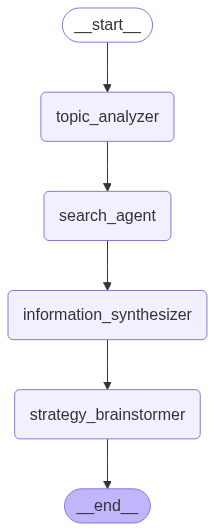

In [ ]:
# ============== 4. Construction du Graphe ==============
workflow = StateGraph(AgentState)

# Ajout des nœuds
workflow.add_node("topic_analyzer", topic_analyzer_node)
workflow.add_node("search_agent", search_agent_node)
workflow.add_node("information_synthesizer", information_synthesizer_node)
workflow.add_node("strategy_brainstormer", strategy_brainstormer_node)

# Définition des transitions (edges)
workflow.set_entry_point("topic_analyzer")
workflow.add_edge("topic_analyzer", "search_agent")
workflow.add_edge("search_agent", "information_synthesizer")
workflow.add_edge("information_synthesizer", "strategy_brainstormer")
workflow.add_edge("strategy_brainstormer", END) # Fin du processus

# Compilation du graphe
app = workflow.compile()
logger.info("Graphe compilé avec succès.")

# Visualisation du graphe (optionnel, mais utile pour la démo)
try:
    # Assurez-vous d'avoir graphviz et pygraphviz installés si vous voulez une image locale:
    # !sudo apt-get install graphviz libgraphviz-dev -y
    # !pip install pygraphviz
    # Ou utilisez Mermaid pour une version textuelle / HTML
    mermaid_graph = app.get_graph().draw_mermaid()
    logger.info("Graphe Mermaid généré. Vous pouvez le visualiser sur mermaid.live.")
    print("\n--- Structure du Graphe (Mermaid) ---")
    print(mermaid_graph)
    print("-----------------------------------\n")
    # Pour afficher l'image directement dans Colab (si mermaid-cli est accessible et configuré)
    img_bytes = app.get_graph().draw_mermaid_png()
    if img_bytes:
      display(Image(img_bytes))
    else:
      logger.warning("Impossible de générer l'image du graphe Mermaid PNG directement.")
except Exception as e:
    logger.error(f"Erreur lors de la génération de la visualisation du graphe : {e}")


In [ ]:
# ============== 5. Exécution de la Démo ==============

initial_topic = "L'impact de l'informatique quantique sur la cybersécurité des entreprises d'ici 2030."
# initial_topic = "L'évolution du rôle des Sales Managers avec l'avènement des outils d'IA générative pour la vente."

# Initialisation de l'état avec les champs pour le débogage
initial_state_input = {
    "original_topic": initial_topic,
    "history": [],
    "debug_messages": [],
    "error_message": None
}

logger.info(f"🚀 Démarrage de l'analyse pour : {initial_topic}\n")

# Utilisation de app.stream() pour observer chaque étape
try:
    for i, output_chunk in enumerate(app.stream(initial_state_input, {"recursion_limit": 10})): # recursion_limit par sécurité
        # output_chunk est un dictionnaire où la clé est le nom du nœud qui vient de s'exécuter
        # et la valeur est l'état du graphe *après* l'exécution de ce nœud.
        executed_node_name = list(output_chunk.keys())[0]
        current_state_after_node = output_chunk[executed_node_name]

        print(f"\nChunk {i+1}: Nœud '{executed_node_name}' exécuté.")
        print("----------------------------------------------------")
        print("Messages de débogage pour cette étape:")
        for msg in current_state_after_node.get("debug_messages", [])[len(initial_state_input.get("debug_messages",[])):]: # Nouveaux messages
            print(f"  - {msg}")
        initial_state_input["debug_messages"] = list(current_state_after_node.get("debug_messages", [])) # Mettre à jour pour la prochaine itération

        if current_state_after_node.get("error_message"):
            print(f"⚠️ ERREUR détectée après '{executed_node_name}': {current_state_after_node['error_message']}")
            # Vous pourriez décider d'arrêter le flux ici si l'erreur est critique
            # break

        # Afficher des informations spécifiques de l'état si pertinent
        if executed_node_name == "topic_analyzer":
            print(f"  Sujet analysé: {current_state_after_node.get('analyzed_topic', {}).get('clarified_topic')}")
        elif executed_node_name == "search_agent":
            print(f"  Nombre de résultats de recherche bruts: {len(current_state_after_node.get('search_results', []))}")
        elif executed_node_name == "information_synthesizer":
            print(f"  Début de la synthèse: {current_state_after_node.get('synthesized_information', '')[:100]}...")
        elif executed_node_name == END: # Le dernier chunk peut être {__end__: AgentState}
             print(f"  Flux terminé. État final en préparation.")


    print("\n🏁 --- ANALYSE TERMINÉE (via stream) --- 🏁")
    # L'état final est dans `current_state_after_node` si le stream s'est bien terminé
    # ou vous pouvez appeler invoke pour être sûr d'avoir l'état final complet.
    final_state = app.invoke(initial_state_input, {"recursion_limit": 10})

except Exception as e:
    logger.error(f"Erreur majeure pendant l'exécution du graphe: {e}", exc_info=True) # exc_info=True pour la traceback
    final_state = {"error_message": f"Erreur critique du graphe: {e}", "original_topic": initial_topic} # État de fallback

ERROR:__main__:Erreur majeure pendant l'exécution du graphe: 'original_topic'
Traceback (most recent call last):
  File "/tmp/ipython-input-28-3001547616.py", line 18, in <cell line: 0>
    for i, output_chunk in enumerate(app.stream(initial_state_input, {"recursion_limit": 10})): # recursion_limit par sécurité
  File "/usr/local/lib/python3.11/dist-packages/langgraph/pregel/__init__.py", line 2542, in stream
    for _ in runner.tick(
  File "/tmp/ipython-input-19-2401614724.py", line 14, in topic_analyzer_node
    topic = state["original_topic"]
            ~~~~~^^^^^^^^^^^^^^^^^^
KeyError: 'original_topic'
During task with name 'topic_analyzer' and id '3509a80c-1933-da98-37d3-f283549f3f36'


In [ ]:
print("\n📊 --- RÉSUMÉ FINAL DE L'ANALYSE --- 📊")
print(f"Sujet Initial: {final_state.get('original_topic')}")

if final_state.get("analyzed_topic"):
    print(f"\nSujet Analysé: {final_state.get('analyzed_topic', {}).get('clarified_topic', 'N/A')}")
    print(f"  Questions Clés: {final_state.get('analyzed_topic', {}).get('key_questions', [])}")
    print(f"  Domaines d'Impact: {final_state.get('analyzed_topic', {}).get('impact_domains', [])}")

if final_state.get("search_results"):
    print(f"\nRésultats de Recherche (extraits):")
    for i, res in enumerate(final_state['search_results'][:2]): # Affiche les 2 premiers
        print(f"  {i+1}. URL: {res.get('url')} - Snippet: {res.get('snippet')}")

if final_state.get("synthesized_information"):
    print(f"\nSynthèse des Informations:\n{final_state['synthesized_information']}")

if final_state.get("strategic_outputs"):
    outputs = final_state['strategic_outputs']
    print(f"\nSorties Stratégiques:")
    if isinstance(outputs, dict) and "raw_text" in outputs and not any(k in outputs for k in ['opportunities', 'threats']):
        print(outputs["raw_text"]) # Affichage brut si le JSON a échoué
    elif isinstance(outputs, dict):
        print(f"  Opportunités: {outputs.get('opportunities', 'N/A')}")
        print(f"  Menaces: {outputs.get('threats', 'N/A')}")
        print(f"  Idées de Contenu: {outputs.get('content_ideas', 'N/A')}")
        print(f"  Action Recommandée: {outputs.get('recommended_action', 'N/A')}")
    else:
        print(str(outputs))


print("\n📜 --- Historique des Nœuds Visit́s --- 📜")
print(" -> ".join(final_state.get("history", ["N/A"])))


print("\n🗒️ --- Messages de Débogage Complets --- 🗒️")
if final_state.get("debug_messages"):
    for msg in final_state["debug_messages"]:
        print(f"  - {msg}")
else:
    print("  Aucun message de débogage enregistré.")


if final_state.get("error_message"): # S'assurer que la dernière erreur est bien affichée
    logger.error(f"Erreur finale enregistrée dans l'état: {final_state['error_message']}")
    print(f"\n⚠️ ERREUR FINALE DANS L'ÉTAT: {final_state['error_message']}")

ERROR:__main__:Erreur finale enregistrée dans l'état: Erreur critique du graphe: 'original_topic'



📊 --- RÉSUMÉ FINAL DE L'ANALYSE --- 📊
Sujet Initial: L'impact de l'informatique quantique sur la cybersécurité des entreprises d'ici 2030.

📜 --- Historique des Nœuds Visit́s --- 📜
N/A

🗒️ --- Messages de Débogage Complets --- 🗒️
  Aucun message de débogage enregistré.

⚠️ ERREUR FINALE DANS L'ÉTAT: Erreur critique du graphe: 'original_topic'
